Student Name: Raymond Shum

Class: CST383-30_SP22

Assignment: Week 7 - HW 7b

Due Date: Feb. 22, 2022

# Predicting used car prices with linear regression
#### Dr. Bruns

In this notebook we'll use experiment with linear regression in the prediction of used car prices.  We'll try different models, use polynomial features, and implement forward feature selection.

### Instructions:
* problems for you to insert code are indicated with lines that begin with #@ followed by a problem number
* always use a 75/25 split when splitting the data into training/test sets
* always use 'random_state = 0' when using test_train_split so that you get the same answers as the model output

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

In [3]:
# switch to seaborn default stylistic parameters
sns.set()
sns.set_context('notebook') 

### Read the Kuiper's 2008 car data
We'll drop the Model and Trim features, as we are interested in making predictions without identifying the exact kind of car.

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/kuiper-2008-cars.csv")
df.drop(['Model', 'Trim'], inplace=True, axis=1)

Are there any NA values in the data set?

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Type      804 non-null    object 
 4   Cylinder  804 non-null    int64  
 5   Liter     804 non-null    float64
 6   Doors     804 non-null    int64  
 7   Cruise    804 non-null    int64  
 8   Sound     804 non-null    int64  
 9   Leather   804 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 62.9+ KB


There appears to be no missing data; at least none in the form of NA values.
Let's look at the relationships between some of the features.

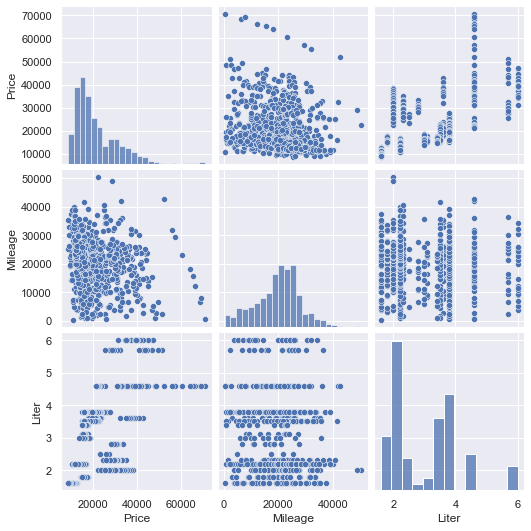

In [6]:
# 1 Produce a grid of scatterplots using only Price, Mileage, and Liter
# Note: use a semicolon after your last plot statement to supress
# the non-graphical output.

sns.pairplot(df[['Price', 'Mileage', 'Liter']]);

What kinds of cars are in the data set and what are their proportions?

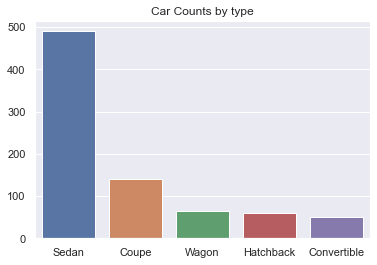

In [7]:
#@ 2 Create a bar plot of the car types, showing the
# number of cars of each type.

data = df['Type'].value_counts()
sns.barplot(x=data.index, y=data.values)
plt.title('Car Counts by type');

Let's build a model to predict a used car's price from its mileage.

In [8]:
#@ 3 Build a linear model using Mileage as the single predictor variable,
# and Price as the target variable.  Fit the model using the entire data set.
# Use the LinearRegression class and use variable 'reg' for your LinearRegression object.

X = df[['Mileage']].values
y = df['Price'].values

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

With one predictor, our linear model can be shown as a line.
Let's look at the model compared to the data.

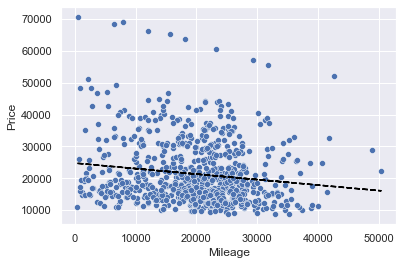

In [9]:
#@ 4 Create a scatterplot of Price by Mileage (Price on y axis),
# then superimpose your linear model on it (as a line).  Do not use
# Seaborn's regplot for this -- use two plotting statements.

sns.scatterplot(data=df, x="Mileage", y="Price")

x_val = df['Mileage'].values
# x & y = b + mx
plt.plot(x_val, reg.intercept_ + reg.coef_ * x_val, color='black', linestyle='dashed') 

What are the coefficients of the model?

In [10]:
#@ 5 Print the coefficients and R-squared value of the model.
# Hint: to get the R-squared value you can use the score() 
# method of LinearRegression.

dict = {
    'intercept': reg.intercept_,
    'coefficient for Mileage': reg.coef_[0],
    'r-squared value': reg.score(X,y)
}

for key, value in dict.items():
    print(f'{key}: {value:.2f}')

intercept: 24764.56
coefficient for Mileage: -0.17
r-squared value: 0.02


The model says that for every extra mile of milage, our prediction for price will go down by 17 cents!  It makes sense that more milage means a lower price.   Let's build another model to predict price, but this time using cruise control and leather interior as additional features.

In [11]:
#@ 6 Create a new linear model for Price using predictors Mileage,
# cruise, and Leather.  Assign your model to variable reg2.

predictors = ['Mileage', 'Cruise', 'Leather']
X = df[predictors]
y = df['Price']

reg2 = LinearRegression()
reg2.fit(X, y)

LinearRegression()

Here are the coefficients of our new model.  

In [12]:
#@ 7 Print the coefficients (including intercept) for the new model.
# Hint: (Use print()'{:.2f}'.format(x)) to print a value
# x with 2 digits after the decimal point.)

print(f'intercept: {reg2.intercept_:.2f}')
print('coefficients:')
for i, coef in enumerate(reg2.coef_):
    print(f'  {predictors[i]}: {coef:.2f}')

intercept: 14297.18
coefficients:
  Mileage: -0.19
  Cruise: 10256.12
  Leather: 4175.58


Amazingly, the coefficient for cruise control indicates that -- in this model -- the presence of cruise control will increase the predicted price by over $10,000.  That seems crazy, but maybe cruise control is a good differentiator between a cheap car and an expensive car.

What would this model predict for the price of a car with 20,000 miles and cruise control but not a leather interior?

In [13]:
#@ 8 Using your model, compute the predicted price for
# a car with a mileage of 20,000 and cruise but no leather.
# Hint: create a matrix to predict() that contains only one row.
# Print the predicted price.  
matrix = pd.DataFrame({
    'Mileage': [20_000],
    'Cruise': [1],
    'Leather': [0]
})

result = reg2.predict(matrix)[0]
print(f'{result:.2f}')

20827.73


A good way to see how well a regression model is working is to plot predicted values against actual values.   In our case we'll plot predicted price vs. actual price.  Ideally, all points will be close to the line showing where actual=predicted.

In [14]:
#@ 9 Define a function named 'plot_actual_predicted' to plot predicted vs actual values.
# It should take as input a NumPy array of actual values, a NumPy array of
# predicted values, and a plot title.  The two arrays can be assumed to be the same length.
# I used linewidth=2 and linestyle='dashed' for the actual=predicted line.
#
# Hint: when plotting, first plot the scatter plot and then plot the line that
# shows when predicted=actual.  You need only two points to plot the line where
# actual = predicted, and the points should have the form (a,a), (b,b).
# To determine what a and b should be, you may want to compute 1) the minimum
# value of actual and predicted, and 2) the maximum value of actual and predicted.

def plot_actual_predicted(actual, predicted, title):
    sns.scatterplot(x=actual, y=predicted)
    # 1 - min value of actual and predicted
    a = (np.min(actual),np.min(predicted))
    # 2 - max value of actual and predicted
    b = (np.max(actual),np.max(predicted))
    # points are plotted in form (a,a) and (b,b)
    plt.plot((a,b), (a,b), color='black', linewidth=2, linestyle='dashed')
    plt.ylabel('predicted')    
    plt.xlabel('actual')
    plt.title(title)


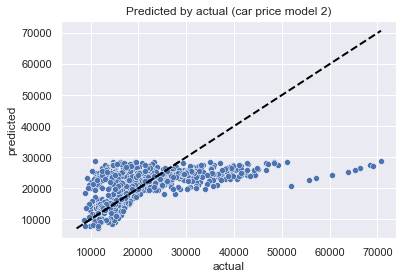

In [15]:
# plot predicted vs. actual for your linear model

plot_actual_predicted(y, reg2.predict(X), 'Predicted by actual (car price model 2)')

The plot shows that many predictions are bad -- they are far off the line.  The points on the far right are cases in which our predicted price is much less than the actual price.  For example, in one of these points the actual price is about 60,000 dollars but our predicted price is about 24,000 dollars.   In the other direction, there's a car with an actual price of about 10,000 in which our model predicts about 25,000.  You wouldn't want to use this model in deciding how much to pay for a used car.

We've been using one data set both to train our model and to make predictions.  It's much better to split the data into separate training and set sets.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Now let's fit our same model using only training data.

In [17]:
#@ 10 Create another linear model (again building a model to predict Price from 
# Mileage, Cruise, and Leather).  Call your new model reg3.  
# However, this time fit the model using the training data.

reg3 = LinearRegression()
reg3.fit(X_train, y_train)

LinearRegression()

Let's plot predicted vs. actual for predictions made on the training set.  This should be similar to our last predicted vs. actual plot.

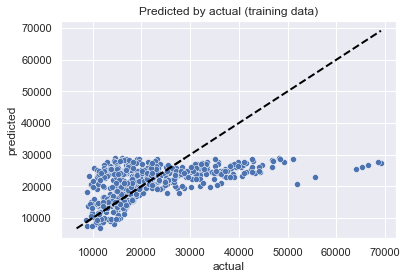

In [18]:
#@ 11 Plot the actual and predicted values using your function
# plot_actual_predicted().
# Use the training data.
title = 'Predicted by actual (training data)'
plot_actual_predicted(y_train, reg3.predict(X_train), title)

Now let's do a predicted vs. actual plot for predictions made on the test data.  

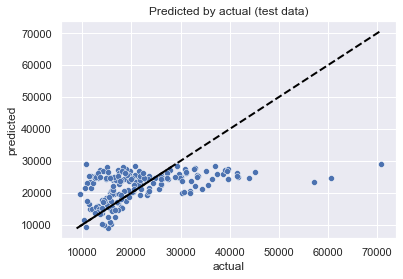

In [19]:
#@ 12 Plot the actual and predicted values using plot_actual_predicted().
# This time use the test data.

title = 'Predicted by actual (test data)'
plot_actual_predicted(y_test, reg3.predict(X_test), title)

The two plots look pretty similar.  Again we see some really bad predictions, like the predicted price of about 28,000 for a car having an actual price of 70,000.

A good way to measure the goodness of a regression model is by using the root mean squared error.

In [20]:
#@ 13 Print the root mean squared error on the test data.  This is the 
# square root of the average squared error.  Write your own code
# to compute the RMSE; don't use a library function.

def rmse(actual, predicted):
    return np.sqrt(((actual - predicted)**2).mean())

rmse = rmse(y_test, reg3.predict(X_test))

print(f'RMSE: {rmse:.2f}')

RMSE: 8517.23


We can make better predictions if we use more features as predictors.  Let's use a feature that represents the number of cylinders in a car's engine.

In [21]:
#@ 14 Create a new model reg4 that is like reg3, but adds 'Cylinder'
# as a new predictor.  Do a train/test split (with random_state = 0), and fit your model to 
# the training data.

pd.options.mode.chained_assignment=None
if 'Cylinder' not in X:
    X['Cylinder'] = df['Cylinder'].copy(deep=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
reg4=LinearRegression()
reg4.fit(X_train, y_train)

LinearRegression()

Let's look at the RMSE of the new model, as well as the R-squared statistic.

In [22]:
# Print the RMSE of your new model on the test data, 
# and R-squared value of your new model (on the training data)

print('RMSE of reg4: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, reg4.predict(X_test)))))
print('r-squared value of reg4: {:.4f}'.format(reg4.score(X_train,y_train)))

RMSE of reg4: 7810.77
r-squared value of reg4: 0.4489


The new cylinder feature reduces the RMSE by over 10 percent.  Let's look at predicted vs. actual for the new model.

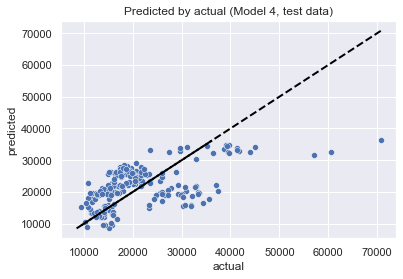

In [23]:
#@ 15 Plot the actual and predicted values using plot_actual_predicted().
# Use test data for your predictions.
title='Predicted by actual (Model 4, test data)'
plot_actual_predicted(y_test,reg4.predict(X_test), title)

Some of the predictions are still really bad.  Would scaling the data help us make better predictions?

In [24]:
#@ 16  Using predictors Mileage, Cruise, Leather, and Cylinder, make
# NumPy arrays X and y, where y contains the values in column Price.
# then scale all columns of array X using scipy.stats.zscore.
# Use X_s as the name of the scaled version of X.

X_s = X.apply(zscore)

Let's check the R-squared score of our new model with scaled data.  How does it compare to the R-squared value above for the unscaled data?

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.25, random_state=0)

regs = LinearRegression()
regs.fit(X_train, y_train)

print('r-squared value of regs: {:.4f}'.format(regs.score(X_train,y_train)))

r-squared value of regs: 0.4489


With Scikit-Learn, all features must be numeric.  Let's now transform all categorical variables into
numeric variables using the dummy variables approach.

In [26]:
#@ 17 Using pandas.get_dummies, convert all the categorical
# columns of df into numerical columns.  Use option drop_first = True
# so that, if the categorical variable has n different unique
# values, then only n-1 dummy variables will be used.

df = pd.get_dummies(df, drop_first=True)

A check to ensure that we now have only numeric variables.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           804 non-null    float64
 1   Mileage         804 non-null    int64  
 2   Cylinder        804 non-null    int64  
 3   Liter           804 non-null    float64
 4   Doors           804 non-null    int64  
 5   Cruise          804 non-null    int64  
 6   Sound           804 non-null    int64  
 7   Leather         804 non-null    int64  
 8   Make_Cadillac   804 non-null    uint8  
 9   Make_Chevrolet  804 non-null    uint8  
 10  Make_Pontiac    804 non-null    uint8  
 11  Make_SAAB       804 non-null    uint8  
 12  Make_Saturn     804 non-null    uint8  
 13  Type_Coupe      804 non-null    uint8  
 14  Type_Hatchback  804 non-null    uint8  
 15  Type_Sedan      804 non-null    uint8  
 16  Type_Wagon      804 non-null    uint8  
dtypes: float64(2), int64(6), uint8(9)
m

Let's build a linear model in which we use all of the features as predictors, and look at the values of all the coefficients.

In [28]:
#@ 18 Make a model with all features.  
# First, create X and y where y contains 'Price' values
# and X contains the other columns of df.
# Next, perform a test train split to get X_train, X_test, etc.
# Then create a linear model using LinearRegression.  Call your model reg5.  
# Finally, print the coefficients of your model (use a loop
# in printing all coefficients except the intercept).

target = 'Price'
predictors = df.columns.tolist()
predictors.remove(target)

y = df[target]
X = df[predictors]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

reg5 = LinearRegression()
reg5.fit(X_train,y_train)

print(f'intercept: {reg5.intercept_:.2f}')
for i, coef in enumerate(reg5.coef_):
    print(f'  {predictors[i]}: {coef:.2f}')

intercept: 34393.88
  Mileage: -0.19
  Cylinder: -1217.73
  Liter: 5674.20
  Doors: -5338.01
  Cruise: 149.11
  Sound: 150.82
  Leather: 112.58
  Make_Cadillac: 15638.25
  Make_Chevrolet: -1616.20
  Make_Pontiac: -1831.79
  Make_SAAB: 10623.51
  Make_Saturn: -1345.82
  Type_Coupe: -12563.40
  Type_Hatchback: -2209.53
  Type_Sedan: -2221.69
  Type_Wagon: 1762.21


It is interesting to look at the coefficient values.  We see that Saab commands a premium price, and that coupes are associated with a low price compared to sedans.  None of the features like cruise control, sound system, or leather seats make a big different in the predictions from this model.

In [29]:
#@ 19 Print the r-squared value for your model based on the training data
# and also print the RMSE based on the test data.

print(f'R-squared: {reg5.score(X_train,y_train):.2f}')

# My RMSE function broke for this problem for some reason
rmse = np.sqrt(((y_test - reg5.predict(X_test))**2).mean())
print(f'RMSE: {rmse:.2f}')

R-squared: 0.94
RMSE: 2685.22


We can add even more features to the model by adding derived features.  Let's try the PolynomialFeatures class.

In [30]:
#@ 20 From your NumPy array X create an extended data set X_poly using
# PolynomialFeatures with degree=2.  Assign your PolynomialFeatures
# object to variable pf.

pf = PolynomialFeatures(degree=2)
pf.fit(X)
X_poly=pf.transform(X)

For a sanity check, how many rows and columns in the new data set?

In [31]:
X_poly.shape

(804, 153)

Let's go for broke and build a model using *all* features.  What is the RMSE on the test data for such a model?

In [32]:
#@ 21 Create a model reg6 using all of these features.  First
# create training and test sets (using X_poly and y), then 
# train a linear model on the training data, and then compute 
# the RMSE on the test data.

X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.25, random_state=0)
reg6 = LinearRegression()
reg6.fit(X_train, y_train)
rmse = np.sqrt(((y_test - reg6.predict(X_test))**2).mean())
print(f'RMSE: {rmse:.2f}')

RMSE: 1446.13


This RMSE value is much lower than before, but our model has 153 features!
It would be good to know which feature is the most important.
As an experiment, let's look at the RMSE if we use only the first feature.

In [33]:
# make a version of the training data with just feature 0
X_0 = X_train[:,[0]]

# compute negated mean square error scores using 5-fold cross validation
scores = cross_val_score(LinearRegression(), X_0, y_train, scoring='neg_mean_squared_error', cv=5)

# work out the average root mean squared error.  We need to
# first negate the scores, because they are negative MSE, not MSE.
rmse = np.sqrt(-scores.mean())

print('RMSE for feature 0 only: {:.2f}'. format(rmse))

RMSE for feature 0 only: 9983.69


Now we'll compute the RMSE for each individual feature, and see which is lowest.

In [34]:
#@ 22 Using the ideas in the last cell, compute the RMSE for each individual 
# feature using 5-fold cross validation.  Save the index and RMSE associated 
# with the best feature as the two variables i_min and rmse_min.

X_rmse = []
num_feat = X_train.shape[1]
for feature in range(num_feat):
    X_feat = X_train[:,[feature]]
    scores = cross_val_score(
        LinearRegression(), 
        X_feat, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=5)
    rmse = np.sqrt(-scores.mean())
    X_rmse.append(rmse)
rmse_min = np.min(X_rmse)
i_min = X_rmse.index(rmse_min)

Which single feature has the lowest RMSE?

In [35]:
print('best feature: {}, best RMSE: {:.2f}'.format(pf.get_feature_names()[i_min], rmse_min))

best feature: x2 x7, best RMSE: 7206.27


Which is the best set of 10 features?  The number of possible sets
of 10 features is equal to 153 * 152 * 151 * ... * 144, which is a gigantic
number (bigger than a billion billion).  Instead we can use forward
feature selection, which is a kind of greedy method.

In [36]:
type(X_feat)

numpy.ndarray

In [37]:
#@ 23 Find the 10 features that give the lowest RMSE by using
# forward search.  Important: find the single best feature, then
# find one more feature that is the best *when combined with
# the single best feature*, and continue, always looking for
# the single best feature combined with all previously-selected
# features.
#
# I've filled in some of the code for you.  'remaining' is a list
# of the features to be considered when finding the next best 
# feature.  It is initialized to all the features.  'selected' is
# a list of the features that have been chosen in a round of finding the
# next best feature.  It is initialized to the empty list.
# 
# Don't forget to have include all selected features when looking
# for the next best feature.

remaining = list(range(X_train.shape[1]))
selected = []
n = 10
while len(selected) < n:
    # find the single features that works best in conjunction
    # with the already selected features
    rmse_min = 1e7
    for i in remaining:
        X_feat = np.hstack((
            X_train[:,selected], 
            X_train[:,[i]]))
        scores = cross_val_score(
            LinearRegression(), 
            X_feat, 
            y_train, 
            scoring='neg_mean_squared_error', 
            cv=5)
        rmse = np.sqrt(-scores.mean())
        if(rmse < rmse_min):
            rmse_min = rmse
            i_min = i
    remaining.remove(i_min)
    selected.append(i_min)
    print('num features: {}; rmse: {:.2f}'.format(len(selected), rmse_min))

num features: 1; rmse: 7206.27
num features: 2; rmse: 5896.86
num features: 3; rmse: 4003.42
num features: 4; rmse: 3568.84
num features: 5; rmse: 3322.06
num features: 6; rmse: 2462.93
num features: 7; rmse: 2293.72
num features: 8; rmse: 2167.47
num features: 9; rmse: 2067.19
num features: 10; rmse: 2009.69


How does the test RMSE of the model created using the 10 features
found with forward feature selection compare with the test RMSE of
the model that uses all the features?

In [38]:
#@ 24 Print the RMSE of the best 10 features on the test set

regr = LinearRegression()
regr.fit(X_train[:,selected], y_train)
predicted = regr.predict(X_test[:,selected])
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print(f'test RMSE with 10 features: {rmse:.2f}')

test RMSE with 10 features: 2075.86
